# Estimating the Optimal Trimming of Reaction Time Data in a Sequential-Sampling Model Framework
~ Noémi Éltető and Attila Krajcsi ~

In simple reaction time tasks dealing with outlier data is difficult, for several reasons. Supposedly, both extremely fast (e.g. 50 ms) and extremely slow (e.g. 5000 ms) reaction times (RTs) are caused by a larger value of the same noise factor. Since this noise is assumed to affect all RTs, controlling for this noise is not trivial. We propose a method to estimate a to-be-trimmed percentage of the RT distribution that maximizes to signal-to-noise ratio. For this end, we use RT data simulated by the simplified version of a plausible and widely used sequential-sampling model.

Sequential-sampling models can explain the RT and error distribution in a single process behavioral task. These models cannot be applied to processing where the decision based on several steps (Wagenmakers et al., 2007, p. 19). Additionally, these decisions are fast, usually they take less than one second.

# The model: How does a diffusion process generate RTs?

First, here are the pre-requisits for the purposes of all the code snippets that we will use in this notebook.

In [3]:
import numpy as np
import pandas as pd
#import seaborn as sns
#sns.set_style("whitegrid")
import matplotlib.pyplot as plt
#plt.style.use('seaborn-deep')
plt.style.use('default')
#from matplotlib.pyplot import cm 
import scipy
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
%matplotlib inline
import matplotlib
#matplotlib.__version__
from collections import OrderedDict

Now we define how the so-called EZ diffusion model accounts for the process that gives rise to a response in a single trial.

In [4]:
def trial(threshold    = 5,
          drift_rate   = 0.01,
          drift_var    = 0.2,
          threshold_low= None,
          start_bias   = 0.0,
          response     = 'e',
          contaminate  = False,
          display      = False):
    """
    Run a single trial, which corresponds to one decision or response where one accuracy and one RT can be measured.
    
    Parameters
    - threshold    : threshold to reach
    - drift_rate   : speed of accumulation of the information
    - drift_var    : random noise in the accumulation of information
    - threshold_low: (optional) if the value is given, then this is the lower threshold, and 'threshold' is 
    the high threshold. Otherwise 'threshold' and -'threshold' will be the two values.
    - start-bias   : starting point of the accumulation
    - response     : if 'r'esponse then give back either -1 or 1
                     if 'e'rror then give back either 0 or 1
    - display      : if True then the trial is displayed on a matplotlib graph
    
    Returns one (accuracy,RT) tuple of type (bool,int).
    """

    if drift_var == 0:
        return None, None
    if not threshold_low:
        threshold_low = -threshold
    evidence = start_bias
    rt = 0
    if not display:
        while (evidence < threshold) and (evidence > threshold_low):
            evidence += np.random.normal(drift_rate, drift_var)
            rt += 1
    else:
        # Like the previous part, but tracks the evidence and displays it
        walk = [evidence]
        while (evidence < threshold) and (evidence > threshold_low):
            evidence += np.random.normal(drift_rate, drift_var)
            walk.append(evidence)
            rt += 1
        plt.plot(walk, c='black')
        plt.axhline(y=start_bias, color='gray')
        plt.axhline(y=0, color='gray')
        plt.ylim((-threshold,threshold))
        plt.xlim((0,1000))
        plt.ylabel('Accumulated evidence')
        plt.xlabel('Time')
        plt.show()
        
    if response == 'e':
        return bool(evidence<0), rt
    elif response == 'r':
        return np.sign(evidence), rt


The next function 'runs' multiple trials. You can think of it as an experiment with one individual or setting, and you can determine the number of trials.

In [56]:
def generate_sample(sample_size=50, diffusion_parameters={'display':False}, contaminate=False, display_distrib=False):
    """
    With the given 'diffusion_parameters', generates an RT sample of 'sample_size'.
    
    Note: 'generate_sample()[:,0]' yields all accuracies, 'generate_sample()[:,1]' yields all RTs.
    
    Parameters
    - sample_size         : size of the RT sample; in other words: number of trials
    - diffusion parameters: the parameters of 'trial' function
    - contaminate         : if 'True', a random delay between 0 and 2000 will be added with 10% percent chance;
                            mimics occasional distraction
    - display_distrib     : if True, overlayed histograms of the RTs of correct and incorrect responses will be generated
    
    Returns a list of [accuracy,RT] two-element lists of size 'sample_size'.
    """
    
    sample = np.array([trial(**diffusion_parameters) for i in xrange(sample_size)])
    if contaminate:
        sample = np.asarray([ list([t[0],t[1]+ np.random.choice(range(0,2000))])
                             if np.random.choice(range(10))==0 else list(t) for t in sample])
    
    if display_distrib:
    
        # All RTs
        all_RTs = sample[:,1]
        # Correct RTs
        correct_RTs = all_RTs[np.array(1-sample[:,0], dtype=bool)]
        # Incorrect RTs
        incorrect_RTs = all_RTs[np.array(sample[:,0], dtype=bool)]
        
        plt.figure(figsize=(3,3))
        plt.hist(correct_RTs, bins=50, color='green', alpha=0.5, label="correct response")
        print 'All RT       | mean: %.2f, median: %.2f, std.dev.: %.2f, skew: %.2f, kurt: %.2f'%(np.mean(all_RTs), np.median(all_RTs), np.std(all_RTs), skew(all_RTs), kurtosis(all_RTs))  

        if incorrect_RTs.size:
            plt.hist(incorrect_RTs, bins=50, color='red', alpha=0.5, label="incorrect response")
            print 'Correct RT   | mean: %.2f, median: %.2f, std.dev.: %.2f, skew: %.2f, kurt: %.2f'%(np.mean(correct_RTs), np.median(correct_RTs), np.std(correct_RTs), skew(correct_RTs), kurtosis(correct_RTs))
            print 'Incorrect RT | mean: %.2f, median: %.2f, std.dev.: %.2f, skew: %.2f, kurt: %.2f'%(np.mean(incorrect_RTs), np.median(incorrect_RTs), np.std(incorrect_RTs), skew(incorrect_RTs), kurtosis(incorrect_RTs))
            print 'Accuracy:    | '+ str((100-float(len(incorrect_RTs))*100/float(len(all_RTs)))) + '%'
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        #plt.legend()
        plt.xlim((0,2000))
        plt.ylim((0,1400))
        #plt.tight_layout()
        #plt.show()
        #plt.clf()   
    return sample

In [57]:
diffusion_parameters_0 = {'threshold':5, 'start_bias':0, 'drift_rate':0.01, 'drift_var':0.2}
diffusion_parameters_1 = {'threshold':6.25, 'start_bias':0, 'drift_rate':0.01, 'drift_var':0.2}
diffusion_parameters_2 = {'threshold':5, 'start_bias':0, 'drift_rate':0.0125, 'drift_var':0.2}
diffusion_parameters_3 = {'threshold':5, 'start_bias':0, 'drift_rate':0.01, 'drift_var':0.25}

param_setting_variations = {'Baseline model' :diffusion_parameters_0,
                            'Increased threshold separation':diffusion_parameters_1,
                            'Increased drift rate'          :diffusion_parameters_2,
                            'Increased drift variance'      :diffusion_parameters_3}

All RT       | mean: 441.15, median: 344.00, std.dev.: 329.25, skew: 1.89, kurt: 5.05
Correct RT   | mean: 442.03, median: 345.00, std.dev.: 329.27, skew: 1.88, kurt: 4.98
Incorrect RT | mean: 429.22, median: 329.00, std.dev.: 328.74, skew: 1.97, kurt: 6.02
Accuracy:    | 93.09%
All RT       | mean: 581.93, median: 470.00, std.dev.: 408.26, skew: 1.81, kurt: 5.19
Correct RT   | mean: 581.25, median: 467.50, std.dev.: 408.85, skew: 1.83, kurt: 5.29
Incorrect RT | mean: 597.76, median: 503.50, std.dev.: 394.19, skew: 1.49, kurt: 2.43
Accuracy:    | 95.86%
All RT       | mean: 349.64, median: 270.00, std.dev.: 273.28, skew: 1.98, kurt: 6.03
Correct RT   | mean: 347.04, median: 267.00, std.dev.: 273.26, skew: 2.02, kurt: 6.36
Incorrect RT | mean: 363.63, median: 288.00, std.dev.: 272.96, skew: 1.75, kurt: 4.34
Accuracy:    | 84.33%
All RT       | mean: 376.14, median: 301.00, std.dev.: 266.72, skew: 1.91, kurt: 5.72
Correct RT   | mean: 377.03, median: 301.00, std.dev.: 268.12, skew: 1.92,

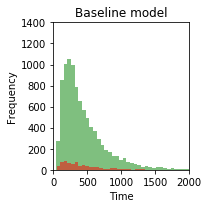

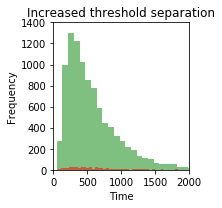

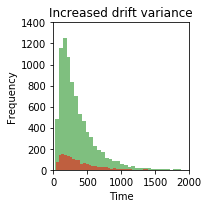

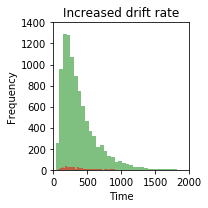

In [58]:
for n,param_setting in enumerate(param_setting_variations.keys()):
    generate_sample(sample_size= 10000, diffusion_parameters=param_setting_variations[param_setting], display_distrib=True)
    plt.title(param_setting)
    plt.tight_layout()
    plt.savefig(param_setting+'.png')

# How does trimming move the mean of small samples?

Our aim is to determine the effects of trimming RT samples. First, we need a function that takes an RT sample, trims a certain amount of the fastest, the slowest or both types of RTs, and then computes statistics for this trimmed RT sample.

In [59]:
def analyze_sample(sample,  benchmark_dict, trim_level=0, trim_mode='symmetrical'):
    """
    Trim a small sample and compute statistics.
    
    Parameters:
    - sample          : np array of error and RT
    - trim_level      : the percentage of the data to be trimmed;
                        if you trim only from one end, it is between 0 and 100
                        if you trim from both ends, it is between 0 and 50
    - trim_mode       : 'lower', 'upper', 'symmetrical'
    - benchmark_dict  : dictionary of the statistics of the big benchmark sample; 'true statistics'
    
    Returns a dictionary of statistics with a structure 'stat name' : 'stat value',
    and a pvalue indicating whether the sample differs from the benchmark.
    """
    
    correct_RTs = sample[:,1][np.array(1-sample[:,0], dtype=bool)]
    trim_value_high = np.percentile(correct_RTs, 100-trim_level)
    trim_value_low = np.percentile(correct_RTs, trim_level)
    if trim_mode == 'symmetrical': # TODO mask array or percentile
        trimmed_sample = [x for x in correct_RTs if (x > trim_value_low) and (x < trim_value_high)]
    elif trim_mode == 'lower':
        trimmed_sample = [x for x in correct_RTs if (x > trim_value_low)]
    elif trim_mode == 'upper':
        trimmed_sample = [x for x in correct_RTs if (x < trim_value_high)]

    statistics = {}
    statistics['mean']  = np.mean(trimmed_sample)
    statistics['median']= np.median(trimmed_sample)
    statistics['std']   = np.std(trimmed_sample)
    
    benchmark = benchmark_dict['mean']
    pvalue = scipy.stats.ttest_1samp(trimmed_sample, benchmark)[1] # returns t and p values, we only use p
    
    return statistics, pvalue

In [60]:
def trim_sample(sample, trim_level=0, trim_mode='symmetrical'):
    """
    Only trim a sample.
    
    Parameters:
    - sample          : np array of error and RT
    - trim_level      : the percentage of the data to be trimmed;
                        if you trim only from one end, it is between 0 and 100
                        if you trim from both ends, it is between 0 and 50
    - trim_mode       : 'lower', 'upper', 'symmetrical'

    Returns a dictionary of statistics with a structure 'stat name' : 'stat value',
    and a pvalue indicating whether the sample differs from the benchmark.
    """
    
    correct_RTs = sample[:,1][np.array(1-sample[:,0], dtype=bool)]
    trim_value_high = np.percentile(correct_RTs, 100-trim_level)
    trim_value_low = np.percentile(correct_RTs, trim_level)
    if trim_mode == 'symmetrical': # TODO mask array or percentile
        trimmed_sample = [x for x in correct_RTs if (x > trim_value_low) and (x < trim_value_high)]
    elif trim_mode == 'lower':
        trimmed_sample = [x for x in correct_RTs if (x > trim_value_low)]
    elif trim_mode == 'upper':
        trimmed_sample = [x for x in correct_RTs if (x < trim_value_high)]
        
    return trimmed_sample

Moving forward, we define a complex function - the simulation function. We generate many small samples; for every small sample, we incrementally trim it and compute the mean in every step. Thus in the end we will have a dataset of the statistics for every trimming level, within every small sample.

In [61]:
def simulation(diffusion_parameters, type_of_analysis, contaminate, benchmark_dict, trimming_range, trim_mode, number_of_samples, sample_size, stat_of_interest):
    """
    - diffusion_parameters : parameters of trial()
    - type_of_analysis     : 'central_tendency' or 'difference_from_benchmark'
    - contaminate          : parameter of generate_sample()
    - benchmark_dict       : dictionary of the statistics of the big benchmark sample; 'true statistics'
    - trimming_range       : range of values that indicate the to-be-trimmed percentile; eg. [1,2,3] in order to trim the 1%, 2%, 3% of the RT data consecutively and non-accumulatively
    - trim_mode            : 'lower', 'upper', 'symmetrical'
    - number_of_samples    : how many small samples are to be generated
    - sample_size          : size of a single sample
    - stat_of_interest     : which statistics are in the focus of the simulation; it has to be a key in the 'statistics' dictionary returned by 'analyze_sample()' e.g. 'mean'
    
    Returns a dataframe containing either the central tendency parameters, or the pvalue for the difference from benchmark, for each sample and trimming level.
    """

    trim_levels = [trim_level for trim_level in trimming_range]
    
    # define the dataframe in which we are to store the sample IDs (rows) and sample stats for trimming levels (columns).
    data = pd.DataFrame(columns=trim_levels)
    
    # generate samples; number and size of samples is taken from the arguments; eg. 100 RT samples of size 50
    for sample_i in range(number_of_samples):
        # generate one small sample; e.g. 50 RTs
        sample = generate_sample(sample_size=sample_size, diffusion_parameters=diffusion_parameters, contaminate=contaminate)
            
        # trim and analyze this sample
        if type_of_analysis == 'central_tendency':
            result = [analyze_sample(sample,  benchmark_dict, trim_level, trim_mode)[0][stat_of_interest] for trim_level in trimming_range]
        elif type_of_analysis == 'difference_from_benchmark':
            result = [analyze_sample(sample, benchmark_dict, trim_level, trim_mode)[1] for trim_level in trimming_range]
        
        data.loc[sample_i] = result
        
        print '{}\r'.format(sample_i),
            
    return data

Our plotting function will display the divergence of the small sample statistics from the 'true statistics' computed by the compute_benchmark_statistics as a function of trimming level.

In [62]:
def plot_trimming_results(df_wide, type_of_analysis, trimming_range, benchmark_dict, ax, pointplot=True, violinplot=True):
    """
    Plot the result of a simulation of trimming effects on a sample.
    
    Parameters:
    - df_wide              : dataframe returned by 'simulation()'; contains the stats of trimmed RT samples
    - type_of_analysis     : 'central_tendency' or 'difference_from_benchmark'
    - trimming_range       : range of values that indicate the to-be-trimmed percentile; eg. [1,2,3] in order to trim the 1%, 2%, 3% of the RT data consecutively and non-accumulatively
    - benchmark_dict (dict): true statistics dict
    - ax                   : subplot on which to plot
    - pointplot            : sample statistics will be represented as individual datapoints
    - violinplot           : sample statistics will be represented as violins (distribution)
    
    Returns one complex plot (overlayed lineplot and violinplot), where trim_level is on the x axis, and stats is on the y axis.
    """

    if type_of_analysis=='central_tendency':
        # take out the value of the statistics of interest
        benchmark = benchmark_dict[stat_of_interest]
        # benchmark mean line
        ax.axhline(y=benchmark, linewidth=5, color = 'k')
        #ax.text(len(trims)-3, benchmark+3,'benchmark '+stat_of_interest)

    trims=list(df_wide.columns)
    
    if pointplot:
        # it is not very efficient to do this in two separate cycles, but this ensures that the same colors will be the same within samples
        for index, row in df_wide.iterrows():
            ax.plot(trims, list(row), 'o', label = index) # points
            # markerfacecolor='None'
            # alpha=0.5
        for index, row in df_wide.iterrows():
            ax.plot(trims, list(row), '-', label = index)  # lines     # lineslinestyle='dashed'
    
    if violinplot:
        data=[]
        positions=[]
        for col in df_wide.columns:
            data.append(df_wide[col]) # create a list of lists, trimming value-wise
            positions.append(col) # trimming levels on x axis

        # aethetic customization
        violin_parts = ax.violinplot(data, positions,
                                     widths=trims[1]-trims[0]-1, # depends on the distance between trimming levels
                                     showmeans=True,
                                     showextrema=False,
                                     showmedians=False)
        
        for vp in violin_parts['bodies']:
            vp.set_facecolor('grey')
            vp.set_edgecolor('black')
            vp.set_linewidth(2)
            vp.set_alpha(1)
        violin_parts['cmeans'].set_edgecolor('white')
        violin_parts['cmeans'].set_linewidth(5)
        violin_parts['cmeans'].set_alpha(1)
         
    xlabels = [str(x)+'%' for x in trims]
    plt.xticks(trims, xlabels)

Finally, the most complex function is one that runs the procedure of incrementally trimming and analyzing small samples for different sample sizes and parameter settings, and plotting the results. Thus we can see how trimming of small RT samples move the statistics relative to the 'true statistics' in cases with more or less data per sample, and with different distribution characteristics.

In [8]:
def simulation_with_different_samples(sample_size_range, param_setting_variations, number_of_samples, type_of_analysis, contaminate):
    """
    Runs the trimming simulation with samples of different sizes and diffusion parameters.
    
    Parameters:
    - sample_size_range        : a list of values that indicate an RT sample size; values will be the parameters of 'generate_sample()'
    - param_setting_variations : a dictionary of diffusion parameters; elements will be the parameters of 'generate_sample()'
    - number_of_samples        : how many small samples should be generated and analyzed per parameter set
    - type_of_analysis     : 'central_tendency' or 'difference_from_benchmark'
    - contaminate              : parameter of generate_sample()
    Returns a plot panel with the results of the simulation with several samples (different sample sizes in columns and different diffusion parameter settings in rows).
    """

    ncols=len(sample_size_range)
    nrows=len(param_setting_variations)

    f, axs = plt.subplots(nrows,ncols,figsize=(14,14), sharex=True, sharey="row")
    # x (trimming levels) is the same on all subplots of the panel; y (statistic) is the same within a parameter setting (same row)

    if type_of_analysis=='central_tendency':
        f.suptitle('Deviation of the ' + str(stat_of_interest) + ' from the benchmark with ' + str(trim_mode) +
           ' trimmed RT distributions and sample sizes', fontsize=20)

    elif type_of_analysis=='difference_from_benchmark':
        f.suptitle('P values for the difference between the sample mean and the benchmark with ' + str(trim_mode) +
           ' trimmed RT distributions and sample sizes', fontsize=20)
    
    for n_row, param_setting in sorted(enumerate(param_setting_variations.keys())):
        print "starting param setting: " + param_setting

        benchmark_sample = generate_sample(sample_size=10000, diffusion_parameters=param_setting_variations[param_setting]) # TODO check, add params
        benchmark_dict = analyze_sample(benchmark_sample, {'mean':0})[0]

        for n_col, sample_size in enumerate(sample_size_range):
            print "starting sample size: " + str(sample_size)

            df_wide = simulation(diffusion_parameters=param_setting_variations[param_setting],
                                 type_of_analysis=type_of_analysis,
                                 contaminate=contaminate,
                                 benchmark_dict=benchmark_dict,
                                 trimming_range=trimming_range,
                                 trim_mode=trim_mode,
                                 number_of_samples=number_of_samples,
                                 sample_size=sample_size,
                                 stat_of_interest=stat_of_interest)

            ax=axs[n_row][n_col]
            if n_col == 0:
                ax.set_ylabel(stat_of_interest + ' of the simulated RTs')
                ax.text(-0.3, 0.5, str(param_setting),
                        transform=ax.transAxes, fontsize=16, va='top', ha='right')
            if n_row == 0:
                ax.set_title('sample size: '+str(sample_size)+'\n', fontsize=16)
            if n_row < 3 :
                ax.set_xlabel('')
            else:
                ax.set_xlabel('trimming values')
           
            if number_of_samples < 50: # for the sake of clarity, pointplot for small sample set, violinplot for large sample set
                plot_trimming_results(df_wide, type_of_analysis, trimming_range, benchmark_dict, ax, violinplot=False)
            else: 
                plot_trimming_results(df_wide, type_of_analysis, trimming_range, benchmark_dict, ax, pointplot=False)

        f.text(0,-0.05,'Notes: ' + str(param_setting_variations), fontsize=8)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

starting param setting: Baseline model
starting sample size: 50
starting sample size: 100
starting sample size: 1000
starting param setting: High threshold separation
starting sample size: 50
starting sample size: 100
starting sample size: 1000
starting param setting: High drift rate
starting sample size: 50
starting sample size: 100
starting sample size: 1000
starting param setting: High drift variance
starting sample size: 50
starting sample size: 100
starting sample size: 1000


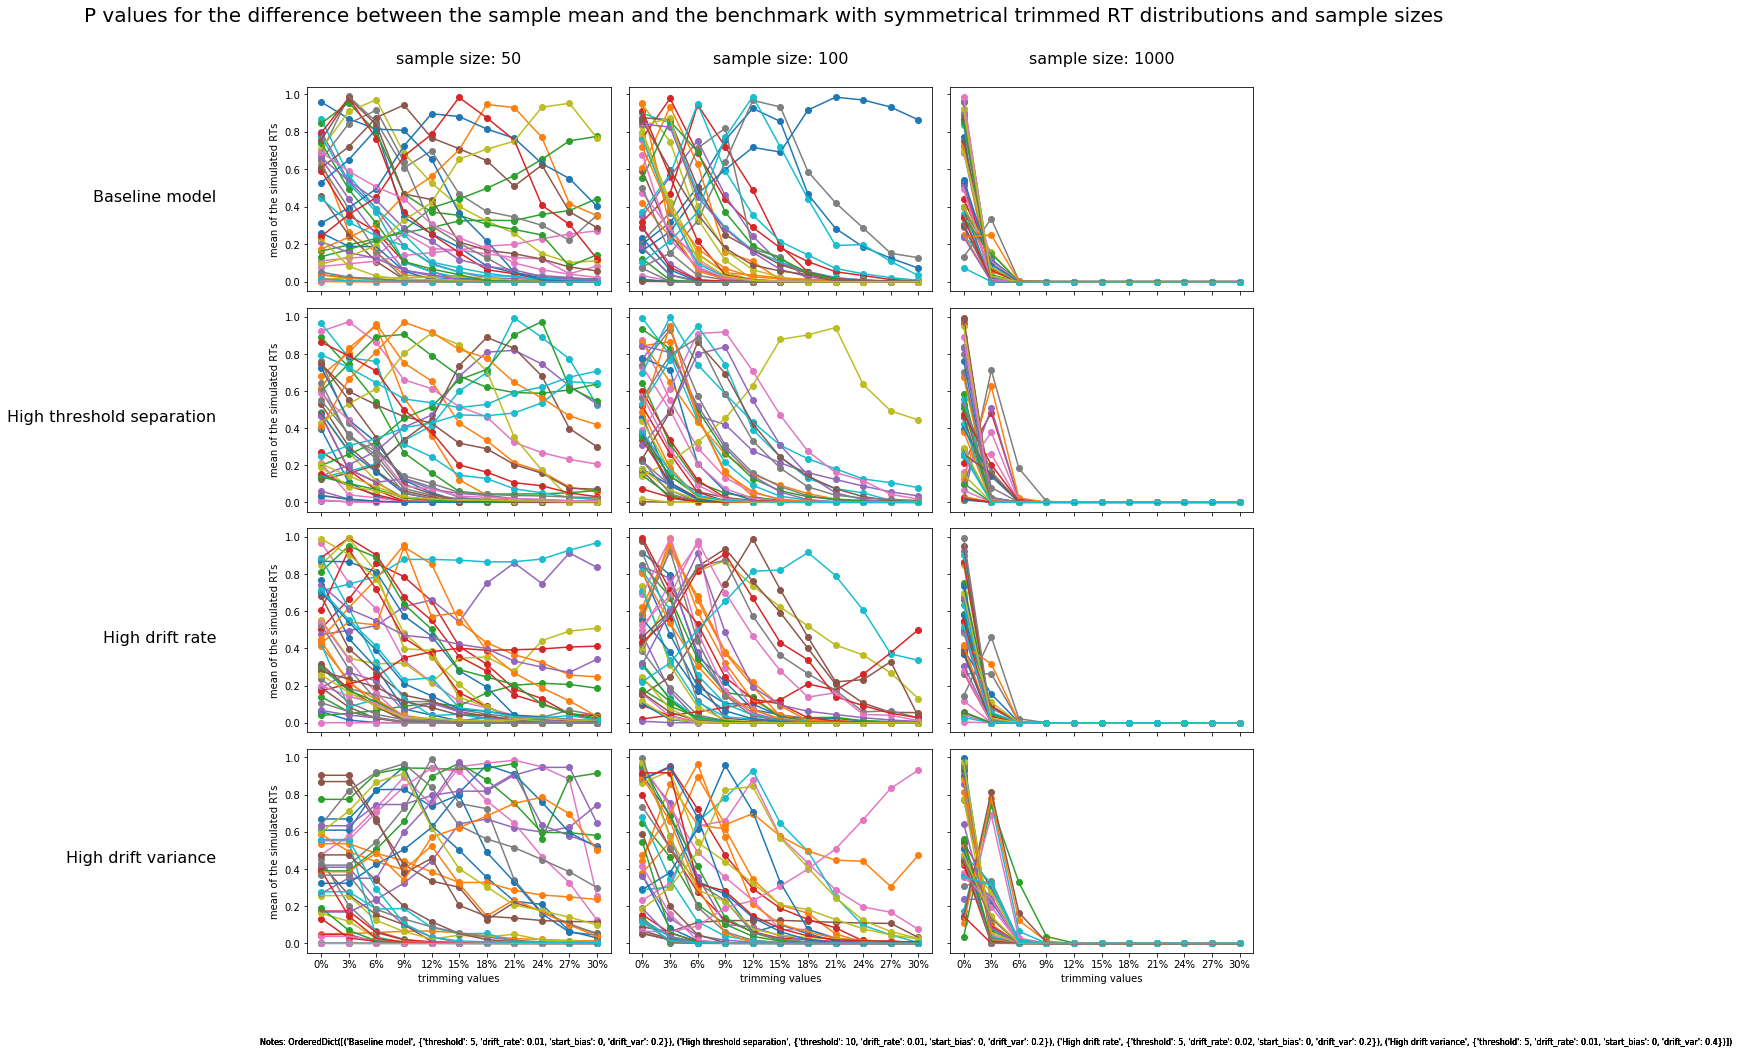

In [11]:
param_setting_variations = [('Baseline model'           ,diffusion_parameters_0),
                            ('High threshold separation',diffusion_parameters_1),
                            ('High drift rate'          ,diffusion_parameters_2),
                            ('High drift variance'      ,diffusion_parameters_3)]
param_setting_variations = OrderedDict(param_setting_variations)

trimming_range = list(np.arange(0, 33, 3))
sample_size_range = [50,100,1000]
stat_of_interest='mean'
trim_mode='symmetrical' # could be upper, lower or symmetrical
contaminate=False
type_of_analysis='difference_from_benchmark'
number_of_samples=40

simulation_with_different_samples(sample_size_range, param_setting_variations, number_of_samples, type_of_analysis, contaminate)

Till now, we focused on the question whether trimming can aid a better central tendency estimation. But in research practice, seldom is important to know the exact value of a behavioral parameter. Most typically, the research hypothesis is a difference between conditions or groups. Therefore, here we assess whether it is more probable to detect a difference between RT samples generated with different parameter sets, if those samples are trimmed.

In [42]:
def power_analysis_with_trimming(sample_size_range, trim_levels, trim_mode, param_setting_variations, number_of_samples, contaminate):

    ncols=len(sample_size_range)
    nrows=len(param_setting_variations)

    f, axs = plt.subplots(nrows,ncols,figsize=(14,14), sharex=True, sharey=True)
    # x (trimming levels) is the same on all subplots of the panel; y (statistic) is the same within a parameter setting (same row)

    f.suptitle('Statistical power of t-tests for the difference between ' + str(trim_mode) +
           ' trimmed RT samples and sample sizes', fontsize=20)
    
    for n_row, param_setting in sorted(enumerate(param_setting_variations.keys())):
        print "starting param setting: " + param_setting        

        for n_col, sample_size in enumerate(sample_size_range):
            print "starting sample size: " + str(sample_size)
            
            # define the dataframe in which we are to store the sample IDs (rows) and sample stats for trimming levels (columns).
            df_wide = pd.DataFrame(columns=trim_levels)
            for sample_i in range(number_of_samples):
                print "starting sample:  " + str(sample_i)
                 
                baseline_sample = generate_sample(sample_size=sample_size, diffusion_parameters=param_setting_variations['Baseline model'], contaminate=contaminate)
                comparison_sample = generate_sample(sample_size=sample_size, diffusion_parameters=param_setting_variations[param_setting], contaminate=contaminate)
            
                result=[]
                for trim_level in trim_levels:
                    
                    baseline_trimmed = trim_sample(baseline_sample, trim_level=trim_level, trim_mode=trim_mode)
                    comparison_trimmed = trim_sample(comparison_sample, trim_level=trim_level, trim_mode=trim_mode)

                    result.append(scipy.stats.ttest_ind(baseline_trimmed, comparison_trimmed)[1])

                df_wide.loc[sample_i] = result
                
            power = [(sum(df_wide[trim_level].where(df_wide[trim_level]<0.05).notnull()))/float(len(df_wide)) for trim_level in df_wide.columns]
            
            ax=axs[n_row][n_col]
            if n_col == 0:
                ax.set_ylabel('statistical power')
                ax.text(-0.3, 0.5, 'Baseline model vs ' + str(param_setting),
                        transform=ax.transAxes, fontsize=16, va='top', ha='right')
            if n_row == 0:
                ax.set_title('sample size: '+str(sample_size)+'\n', fontsize=16)
            if n_row < 3 :
                ax.set_xlabel('')
            else:
                ax.set_xlabel('trimming values')
           
            ax.plot(trim_levels, power)
            
        f.text(0,-0.05,'Notes: ' + str(param_setting_variations), fontsize=8)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
            

In [73]:
def power_analysis_with_trimming(sample_size_range, trim_levels, trim_mode, param_setting_variations, number_of_samples, contaminate):

    sample_size_colors = {50:'darkred',100:'coral',500:'seagreen'}
    ncols=len(param_setting_variations)

    f, axs = plt.subplots(1,ncols,figsize=(14,3), sharex=True, sharey=True)
    f.suptitle('Statistical power of t-tests for the difference between ' + str(trim_mode) +' trimmed RT samples', fontsize=20)
    
    for n_col, param_setting in sorted(enumerate(param_setting_variations.keys())):
        print "starting param setting: " + param_setting        

        for sample_size in sample_size_range:
            print "starting sample size: " + str(sample_size)
            
            # define the dataframe in which we are to store the sample IDs (rows) and sample stats for trimming levels (columns).
            df_wide = pd.DataFrame(columns=trim_levels)
            for sample_i in range(number_of_samples):
                print "starting sample:  " + str(sample_i)
                 
                baseline_sample = generate_sample(sample_size=sample_size, diffusion_parameters=param_setting_variations['Baseline model'], contaminate=contaminate)
                comparison_sample = generate_sample(sample_size=sample_size, diffusion_parameters=param_setting_variations[param_setting], contaminate=contaminate)
            
                result=[]
                for trim_level in trim_levels:
                    
                    baseline_trimmed = trim_sample(baseline_sample, trim_level=trim_level, trim_mode=trim_mode)
                    comparison_trimmed = trim_sample(comparison_sample, trim_level=trim_level, trim_mode=trim_mode)

                    result.append(scipy.stats.ttest_ind(baseline_trimmed, comparison_trimmed)[1])

                df_wide.loc[sample_i] = result
                
            power = [(sum(df_wide[trim_level].where(df_wide[trim_level]<0.05).notnull()))/float(len(df_wide)) for trim_level in df_wide.columns]
            
            ax=axs[n_col]
            ax.set_title('Baseline model vs '+ param_setting)
            ax.set_xlabel('trimming (%)')
            ax.plot(trim_levels, power, color=sample_size_colors[sample_size],label=sample_size)
            if n_col == 0:
                ax.set_ylabel('statistical power')
                ax.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.80)

starting param setting: Baseline model
starting sample size: 50
starting sample:  0
starting sample:  1
starting sample:  2
starting sample:  3
starting sample:  4
starting sample:  5
starting sample:  6
starting sample:  7
starting sample:  8
starting sample:  9
starting sample:  10
starting sample:  11
starting sample:  12
starting sample:  13
starting sample:  14
starting sample:  15
starting sample:  16
starting sample:  17
starting sample:  18
starting sample:  19
starting sample:  20
starting sample:  21
starting sample:  22
starting sample:  23
starting sample:  24
starting sample:  25
starting sample:  26
starting sample:  27
starting sample:  28
starting sample:  29
starting sample:  30
starting sample:  31
starting sample:  32
starting sample:  33
starting sample:  34
starting sample:  35
starting sample:  36
starting sample:  37
starting sample:  38
starting sample:  39
starting sample:  40
starting sample:  41
starting sample:  42
starting sample:  43
starting sample:  44
s

starting sample:  83
starting sample:  84
starting sample:  85
starting sample:  86
starting sample:  87
starting sample:  88
starting sample:  89
starting sample:  90
starting sample:  91
starting sample:  92
starting sample:  93
starting sample:  94
starting sample:  95
starting sample:  96
starting sample:  97
starting sample:  98
starting sample:  99
starting sample size: 100
starting sample:  0
starting sample:  1
starting sample:  2
starting sample:  3
starting sample:  4
starting sample:  5
starting sample:  6
starting sample:  7
starting sample:  8
starting sample:  9
starting sample:  10
starting sample:  11
starting sample:  12
starting sample:  13
starting sample:  14
starting sample:  15
starting sample:  16
starting sample:  17
starting sample:  18
starting sample:  19
starting sample:  20
starting sample:  21
starting sample:  22
starting sample:  23
starting sample:  24
starting sample:  25
starting sample:  26
starting sample:  27
starting sample:  28
starting sample:  

starting sample:  69
starting sample:  70
starting sample:  71
starting sample:  72
starting sample:  73
starting sample:  74
starting sample:  75
starting sample:  76
starting sample:  77
starting sample:  78
starting sample:  79
starting sample:  80
starting sample:  81
starting sample:  82
starting sample:  83
starting sample:  84
starting sample:  85
starting sample:  86
starting sample:  87
starting sample:  88
starting sample:  89
starting sample:  90
starting sample:  91
starting sample:  92
starting sample:  93
starting sample:  94
starting sample:  95
starting sample:  96
starting sample:  97
starting sample:  98
starting sample:  99
starting sample size: 500
starting sample:  0
starting sample:  1
starting sample:  2
starting sample:  3
starting sample:  4
starting sample:  5
starting sample:  6
starting sample:  7
starting sample:  8
starting sample:  9
starting sample:  10
starting sample:  11
starting sample:  12
starting sample:  13
starting sample:  14
starting sample:  

starting sample:  55
starting sample:  56
starting sample:  57
starting sample:  58
starting sample:  59
starting sample:  60
starting sample:  61
starting sample:  62
starting sample:  63
starting sample:  64
starting sample:  65
starting sample:  66
starting sample:  67
starting sample:  68
starting sample:  69
starting sample:  70
starting sample:  71
starting sample:  72
starting sample:  73
starting sample:  74
starting sample:  75
starting sample:  76
starting sample:  77
starting sample:  78
starting sample:  79
starting sample:  80
starting sample:  81
starting sample:  82
starting sample:  83
starting sample:  84
starting sample:  85
starting sample:  86
starting sample:  87
starting sample:  88
starting sample:  89
starting sample:  90
starting sample:  91
starting sample:  92
starting sample:  93
starting sample:  94
starting sample:  95
starting sample:  96
starting sample:  97
starting sample:  98
starting sample:  99


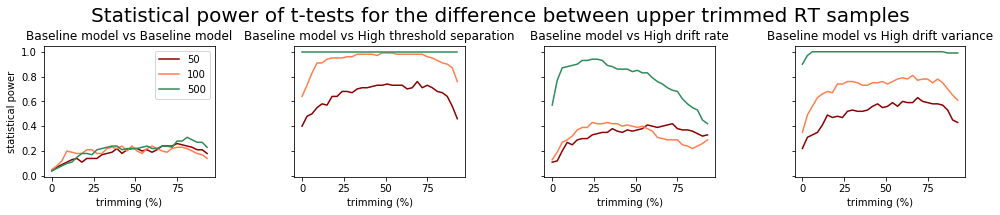

In [76]:
diffusion_parameters_0 = {'threshold':5, 'start_bias':0, 'drift_rate':0.01, 'drift_var':0.2}
diffusion_parameters_1 = {'threshold':6.25, 'start_bias':0, 'drift_rate':0.01, 'drift_var':0.2}
diffusion_parameters_2 = {'threshold':5, 'start_bias':0, 'drift_rate':0.0125, 'drift_var':0.2}
diffusion_parameters_3 = {'threshold':5, 'start_bias':0, 'drift_rate':0.01, 'drift_var':0.25}

# the parameters are modified by 25% for each different setting respectively

param_setting_variations = [('Baseline model'           ,diffusion_parameters_0),
                            ('High threshold separation',diffusion_parameters_1),
                            ('High drift rate'          ,diffusion_parameters_2),
                            ('High drift variance'      ,diffusion_parameters_3)]
param_setting_variations = OrderedDict(param_setting_variations)

trimming_range = list(np.arange(0, 96, 3))
sample_size_range = [50,100,500]
trim_mode='upper' # could be upper, lower or symmetrical
number_of_samples=100

power_analysis_with_trimming(sample_size_range=sample_size_range,
                             trim_levels=trimming_range,
                             trim_mode=trim_mode,
                             param_setting_variations=param_setting_variations,
                             number_of_samples=number_of_samples,
                             contaminate = True)